In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata

## Cumulative Distribution
$\tau$ is current time, $t$ is time step (delta_t)
$$ F_{\tau}(t) = 1 - \exp \Big\{ - \int_{\tau}^{\tau+t} \lambda(s) {d}s \Big\} $$

draw $t \sim f_{\tau}(t) = \frac{\partial}{\partial t} (F_{\tau} (t) ) $

Inverse transformation sampling --> draw uniform number $u \in [0,1]$ and find inverse CDF $F_{\tau}^{-1}(u) = T $--> returns the largest $t$ from the domain of the PDF such that $\mathbb{P}(-\infty < T < t) \leq u$

Specifically, if $u$ has a uniform distribution on $[0,1]$ and if $T$ has a cumulative distribution $F_{\tau}$ then the random variable $F_{\tau}^{-1}(u)$ has the same distribution as $T$. 

In [13]:
def CDF(max_time, dt, tau, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, Input, B ):
    N = sum(Input)
    tt = np.arange(0,max_time, dt)    
    
    mt = (sigma*Input[1] + (omega+mort*mu1)*Input[2] +
         (mort*mu2 + (1-mort)*mu2)*Input[3] + 
         (beta/N)*Input[0]*(Input[2]+alpha*Input[3]))*tt - (1/B)*epsilon_vector(B,tt,tau, epsilon)*Input[0]
    
#     mt = (1/2)*tt
    F = 1 - np.exp(-mt)
#     print(epsilong(B,tt,tau, epsilon))
    return tt, F, mt
    

In [14]:
def epsilon_vector(bb, tt, tau, e):
    eps = np.zeros(len(tt))
#     eps = 0
#     if np.sin(bb*tt)>=0:
#         eps = (e/bb)*(np.cos(bb*(tt+tau))-np.cos(bb*tau))
    y = np.where(np.sin(bb*(tt))>=0)
    y = np.array(y)[0]
    eps[y] = ([(e/bb)*(np.cos(bb*(tt[i]+tau))-np.cos(bb*tau)) for i in y])
    return eps

In [15]:
def epsilon_scalar(bb, tt, tau, e):
#     eps = np.zeros(len(tt))
    eps = 0
    if np.sin(bb*tt)>=0:
        eps = (e/bb)*(np.cos(bb*(tt+tau))-np.cos(bb*tau))
#     y = np.where(np.sin(bb*(tt))>=0)
#     y = np.array(y)[0]
#     eps[y] = ([(e/bb)*(np.cos(bb*(tt[i]+tau))-np.cos(bb*tau)) for i in y])
    return eps

In [16]:
cdf_rate = CDF(1000, 0.01,0, 1.3, 1/7, 1/5, 1/5, 1/12, 0.001, 1, 0.7, [1500,1,0,0], 2*np.pi/365)

In [17]:
tt = np.arange(0,10, 0.001)
# [(1/(2*np.pi/365))*(np.maximum(np.cos((2*np.pi/365)*(tt +1)),0) -np.maximum(np.cos((2*np.pi/365)*1),0))*1000 if ]

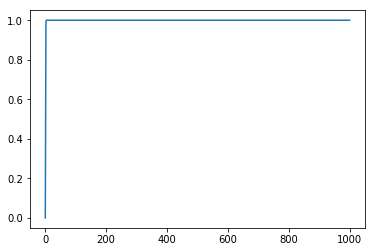

In [18]:
plt.plot(cdf_rate[0], cdf_rate[1])

In [19]:
def inverseCDF(t, F):
    r = np.random.uniform(0,1)
    s2 = np.min(np.where(F>r))
    s1 = s2-1
    
    y2,y1 = F[s2], F[s1]
    x2, x1 = t[s2], t[s1]
    
    m = (y2-y1)/(x2-x1)
    tt = (r-y1)/m + x1
    return tt

In [20]:
inverseCDF(cdf_rate[0], cdf_rate[1])

1.0293645976169077

In [21]:
time_steps = []
for l in range(10000):
    time_steps.append(inverseCDF(cdf_rate[0], cdf_rate[1]))

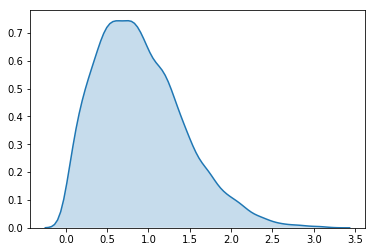

In [22]:
sns.kdeplot(time_steps, shade = True)
# plt.hist(time_steps)

# Adaptive Gillespie

### Parameters

In [28]:
β = 0.005
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 265
γ = 1/(80*365)
period = (2*np.pi)/365
Input_H = [1500,1,0,0,0]
Nn = sum(Input_H)

In [32]:
def changingGillespie(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, B,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time :
        state = np.zeros(shape= (5,12))
        ####################################################################################
        ##################################### TIME #########################################
        ####################################################################################
        Cdensity = CDF(100, 0.01, times, beta, mu1,mu2, sigma, 
                       omega,epsilon,alpha, mort, pop[ind], B)
        
        delta_t = inverseCDF(Cdensity[0], Cdensity[1])
        
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = (delta_t*beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N - 
                pop[ind][0]*epsilon_scalar(B, times, delta_t,epsilon))
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = delta_t*sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = delta_t*omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = delta_t*mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = delta_t*mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = delta_t*(1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]

        R_hs = delta_t*(1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]

        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        print(delta_t, times)
        Rtotal = sum(rate)

        P = np.random.uniform(0,1)*Rtotal

        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
        else:
            times =times+ delta_t
            events.append(-1)
            event_append(times)
            print('zero')
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 +cuminf[ind])
        else:
            cuminf.append(0 + cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events, cuminf

In [33]:
cG = changingGillespie(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, period, capT)
SEIHRt = cG[0]
SEIHRs = cG[1][:,0]
SEIHRe = cG[1][:,1]
SEIHRi = cG[1][:,2]
SEIHRh = cG[1][:,3]
SEIHRr = cG[1][:,4]

1.4497827423303602 0
2.584629356932597 1.4497827423303602
1.2750641166592516 4.034412099262957
0.14576702683343012 5.309476215922208
0.024214713499075734 5.455243242755638
0.6238622670668448 5.479457956254714
1.7600407768416606 6.103320223321559
0.968715055690189 7.863361000163219
0.9070198765364775 8.832076055853408
0.17970496036055514 9.739095932389885
0.4934698274733833 9.91880089275044
0.6698692087938247 10.412270720223823
1.448847293404557 11.082139929017648
0.17427833349609317 12.530987222422205
0.32298930081108485 12.705265555918299
0.6697465879396433 13.028254856729383
1.4044872396498174 13.698001444669027
0.010872532987135749 15.102488684318844
0.20239137901975424 15.11336121730598
0.24528573663487815 15.315752596325735
0.023955999756044708 15.561038332960614
0.001181627518363069 15.584994332716658
0.06973720908025452 15.586175960235021
0.32205570464976424 15.655913169315276
0.10310168421042071 15.977968873965041
1.3777734599618185 16.081070558175462
0.05924749818603215 17.458

0.0409898594310603 33.86764515452391
0.15606778556671647 33.90863501395497
0.06460105801063562 34.06470279952169
0.005155160123779961 34.12930385753233
0.006113418837389465 34.134459017656106
0.016617544831739293 34.14057243649349
0.01648078542033504 34.15718998132523
0.0588824701020581 34.173670766745566
0.039483450020031334 34.23255323684762
0.10324250650704786 34.27203668686765
0.034700135979588376 34.3752791933747
0.007654499400668405 34.40997932935429
0.029682798318364005 34.41763382875496
0.006044754579622631 34.44731662707332
0.014591088292771202 34.45336138165294
0.116841137664992 34.46795246994571
0.03648677703084012 34.5847936076107
0.14255699071708927 34.62128038464154
0.03635551477214463 34.76383737535863
0.008326679491029177 34.80019289013077
0.0035055754674072066 34.8085195696218
0.0017081064306714287 34.81202514508921
0.004210939281377689 34.81373325151988
0.0009946907064274661 34.817944190801256
0.012490772593049128 34.818938881507684
0.011146203698942212 34.83142965410

0.007558400407830381 39.23573707029919
0.014952430976972296 39.24329547070702
0.01104101592599447 39.25824790168399
0.04242450695043222 39.269288917609984
0.03966592735701477 39.311713424560416
0.015510060826747798 39.35137935191743
0.008408002203108554 39.36688941274418
0.01880360143702657 39.37529741494729
0.004294070194386716 39.39410101638432
0.012391268316701167 39.3983950865787
0.009385088412778157 39.4107863548954
0.010742535605285557 39.42017144330818
0.0031465671558618805 39.430913978913466
0.0050085266406752265 39.434060546069325
0.008134912587491114 39.43906907271
0.022119130376356162 39.44720398529749
0.03845333929659661 39.469323115673845
0.06761016529168123 39.50777645497044
0.022246011863895628 39.57538662026212
0.006850096008015089 39.597632632126015
0.007218000497991802 39.60448272813403
0.024190445248935454 39.61170072863202
0.01909722277922452 39.63589117388096
0.013247751696300526 39.65498839666018
0.03821780966165364 39.66823614835648
0.02417172573197155 39.7064539

0.0028787694461233407 42.56567926313188
0.015528612207807303 42.568558032578
0.003990742905628169 42.584086644785806
0.01693589754784111 42.588077387691435
0.007957802807940131 42.605013285239274
0.017415471567147386 42.61297108804721
0.008586461530706583 42.63038655961436
0.006848992773696812 42.63897302114506
0.007781796770565073 42.64582201391876
0.036522164940477275 42.653603810689326
0.02459380191878484 42.690125975629805
0.010506378885375449 42.71471977754859
0.03357814140732008 42.72522615643396
0.0008384663656259937 42.75880429784128
0.008583426668818063 42.75964276420691
0.0034474387575424955 42.76822619087573
0.009428474291644782 42.77167362963327
0.03593518031368565 42.781102103924916
0.003253519141440216 42.8170372842386
0.0026456880523439367 42.82029080338004
0.015632099250458997 42.82293649143239
0.0007947092278711342 42.83856859068285
0.0019310752506611947 42.839363299910715
0.02541611931131133 42.841294375161375
0.005361353493176916 42.866710494472684
0.0132257856490126

0.023311233832061306 44.95495877546778
0.0014848189026855792 44.97827000929984
0.006803583386801642 44.97975482820252
0.00918114247644723 44.98655841158932
0.01019001140533432 44.99573955406577
0.014357600199838803 45.00592956547111
0.0005608563317630339 45.02028716567094
0.012917073331077932 45.02084802200271
0.0019341934547089758 45.033765095333784
0.0008412489705414897 45.03569928878849
0.00915432780121784 45.03654053775904
0.02504615619044304 45.04569486556026
0.008256417732245174 45.0707410217507
0.02418263307855854 45.07899743948295
0.0020211533349778457 45.10318007256151
0.008315944264643852 45.10520122589649
0.008206898242892498 45.11351717016113
0.0032879983356507623 45.12172406840402
0.01973457679893647 45.12501206673967
0.0020037751105533696 45.14474664353861
0.005050283452600019 45.14675041864916
0.0005441229825285325 45.15180070210176
0.008221003327656351 45.152344825084285
0.006895546686378535 45.16056582841194
0.00948219214481865 45.16746137509832
0.015595715670693469 45

0.009586018502649195 46.92311605788533
0.005281552852870023 46.93270207638798
0.0004581026625030123 46.937983629240854
0.002959118786499799 46.93844173190336
0.006504931302463924 46.94140085068986
0.011268758327502862 46.947905781992326
0.018287681678583217 46.95917454031983
0.003759204609008917 46.977462221998415
0.0017671861420880807 46.981221426607426
0.010896062709848837 46.982988612749516
0.03675283821259682 46.99388467545936
0.004487164984347433 47.03063751367196
0.00033846414915064254 47.03512467865631
0.00856302690760935 47.03546314280546
0.0029803393376681628 47.04402616971307
0.007240372798142523 47.04700650905074
0.0034586419377773477 47.05424688184888
0.0008016940774114717 47.05770552378666
0.008826916570845007 47.05850721786407
0.00026805713420374413 47.067334134434915
0.006365187735195188 47.06760219156912
0.00507620402666779 47.07396737930432
0.000678595800821944 47.079043583330986
0.009503446384537387 47.07972217913181
0.0073206261250020315 47.08922562551634
0.014593026

0.003370873495437695 48.648625196319486
0.0019993806686473743 48.65199606981492
0.007335848024273665 48.65399545048357
0.006978819058752595 48.66133129850785
0.0008403604369594305 48.6683101175666
0.009762414347761776 48.66915047800356
0.0010725799774292646 48.67891289235132
0.00310855642175596 48.67998547232875
0.0059812006688200765 48.68309402875051
0.008049416941298411 48.68907522941933
0.018918585164265533 48.69712464636063
0.007678086634417296 48.71604323152489
0.005814224889418655 48.72372131815931
0.005512167450230514 48.72953554304873
0.009141204440380867 48.73504771049896
0.0008046359296281852 48.74418891493934
0.003245269566195408 48.74499355086897
0.015784017292266715 48.74823882043516
0.0005891679130553473 48.76402283772743
0.001052808059484378 48.76461200564049
0.002318370371224518 48.76566481369997
0.00046187762586538076 48.7679831840712
0.008909364407864422 48.768445061697065
0.008914533015639936 48.77735442610493
0.008874769365058951 48.78626895912057
0.0075484400364446

0.007975143891044457 50.3091741343558
0.0035739320983756255 50.317149278246845
0.00812664350934636 50.32072321034522
0.010635153774954526 50.32884985385457
0.01585190117846489 50.33948500762953
0.0003220531194108343 50.35533690880799
0.004227638015757437 50.3556589619274
0.0035489337799005398 50.35988659994316
0.006638406053243033 50.36343553372306
0.01853729537327454 50.370073939776304
0.0033094508407190146 50.38861123514958
0.00606990433323928 50.3919206859903
0.004763194784849939 50.39799059032354
0.01875184136727616 50.40275378510839
0.0012667074662821274 50.421505626475664
0.00415326059876189 50.42277233394194
0.01924278266144018 50.426925594540705
0.003928525222879446 50.44616837720215
0.023388922493213407 50.45009690242503
0.004674917933298658 50.47348582491824
0.003516662155180958 50.47816074285154
0.004770057317995963 50.48167740500672
0.0006309583067273246 50.48644746232472
0.0032098011070041555 50.48707842063145
0.0022852339009318784 50.49028822173845
0.0009405530861677965 5

0.007531183578527008 51.85146687267141
0.003193045719625653 51.85899805624994
0.0041851885611202755 51.862191101969564
0.0021910860276708717 51.86637629053069
0.0017439039940883726 51.86856737655836
0.005984231958461055 51.87031128055245
0.005693628473141246 51.87629551251091
0.015193395999342867 51.88198914098405
0.004100818732140959 51.89718253698339
0.008709074433145317 51.90128335571553
0.015841665999994238 51.90999243014867
0.006986841121509732 51.92583409614866
0.005918106592699913 51.93282093727017
0.0014379955809794701 51.938739043862874
0.0017413136824648995 51.94017703944385
0.0032389145955614403 51.94191835312632
0.004361022365599887 51.94515726772188
0.0015924221864120603 51.94951829008748
0.005111788745797081 51.951110712273895
0.004631922342965292 51.956222501019695
0.005384695304637848 51.96085442336266
0.009535646142682028 51.966239118667296
0.0034287362435829797 51.97577476480998
0.015085482573226186 51.97920350105356
0.006840657864269943 51.99428898362679
0.0001731740

0.0008780474207070465 53.15729270761326
0.008020317313381214 53.158170755033964
0.007803070272775426 53.166191072347345
0.0027605137715523906 53.173994142620124
0.007923571998749896 53.17675465639168
0.006896405876674916 53.18467822839043
0.008660844489562938 53.191574634267106
0.007510229324396042 53.20023547875667
0.005463217028310401 53.20774570808106
0.008756574542397004 53.21320892510937
0.002804257124786527 53.221965499651766
0.007615862140991644 53.22476975677655
0.0005490047459434017 53.23238561891755
0.01207109147629053 53.23293462366349
0.016627717588262925 53.24500571513978
0.005134076405687973 53.26163343272805
0.00962558104130272 53.266767509133736
0.0010752613821044543 53.27639309017504
0.0024712990224341454 53.27746835155715
0.005205151337065409 53.27993965057958
0.008395364630809157 53.285144801916644
0.00872265762632578 53.29354016654745
0.005878526404073982 53.30226282417378
0.0012511260707246596 53.308141350577856
0.004664695114482705 53.30939247664858
0.008245566195

0.005847612933506511 54.5441304860262
0.020819450268470843 54.549978098959706
0.009470486231113726 54.570797549228175
0.0017490868845435388 54.58026803545929
0.0032462162668656677 54.582017122343835
0.005543345917699219 54.5852633386107
0.007201394755281916 54.5908066845284
0.0007713382870880023 54.59800807928369
0.001308075602879605 54.598779417570775
0.0011916758787876155 54.60008749317365
0.008847681565045307 54.60127916905244
0.012895977152426009 54.61012685061748
0.005481342653249489 54.62302282776991
0.00222607786822401 54.628504170423156
0.0031983161821871166 54.63073024829138
0.0035711030909214613 54.633928564473564
0.003796216792983597 54.637499667564484
0.013833526007010512 54.64129588435747
0.0035555098999222284 54.65512941036448
0.007198193035607655 54.658684920264406
0.0035169684272691386 54.66588311330001
0.0174468350312597 54.66940008172728
0.0020204399449257025 54.68684691675854
0.0011535058771794968 54.68886735670347
0.0037583345428867437 54.690020862580646
0.009766918

0.002668191866902087 55.999668694928296
0.001438850488723967 56.0023368867952
0.008168364068982312 56.003775737283924
0.006386241531176442 56.0119441013529
0.010692206245378472 56.01833034288408
0.005602052076627044 56.02902254912946
0.0023646288966964863 56.03462460120608
0.004944326978578649 56.036989230102776
0.00949459498057431 56.04193355708136
0.0017111688037154404 56.05142815206193
0.011278822554155276 56.05313932086565
0.005453499775705265 56.0644181434198
0.016881209237369448 56.069871643195505
0.009687668063955804 56.08675285243287
0.006857312521116711 56.09644052049683
0.015647031097571464 56.10329783301795
0.0042338608218171064 56.11894486411552
0.0037753863156882034 56.12317872493734
0.009615879596943844 56.12695411125303
0.004168434896306178 56.13656999084997
0.0008193158666112796 56.14073842574628
0.012138059126756784 56.14155774161289
0.00040515926516287564 56.15369580073965
0.0029889596944629743 56.15410096000481
0.01700240679596204 56.157089919699274
0.005804585085377

0.0035308213186311427 57.32956379755151
0.005744427477346366 57.33309461887014
0.0026765255133493187 57.33883904634749
0.009077438735026097 57.34151557186084
0.009567037534322205 57.350593010595865
0.002437191553118592 57.36016004813019
0.00280081814884313 57.36259723968331
0.0001221805969357449 57.36539805783215
0.00503463080745389 57.365520238429085
0.0008367258109042578 57.370554869236535
0.009685854950725714 57.37139159504744
0.00732964096386846 57.381077449998166
0.003769984954322151 57.38840709096203
0.004757015646288045 57.39217707591636
0.000503210045307321 57.39693409156265
0.008440879469739072 57.39743730160796
0.006860133477785129 57.405878181077696
0.00233908600921636 57.41273831455548
5.403686823727056e-05 57.4150774005647
0.0013656824472100875 57.41513143743293
0.0071441175661998545 57.41649711988014
0.0060670918546274315 57.42364123744634
0.008368260809186224 57.429708329300965
0.004995610014670286 57.43807659011015
0.004771085451042936 57.44307220012482
0.00034564134164

0.009054570689711154 58.57085902884915
0.005811607408907648 58.57991359953886
0.00022346554170664105 58.58572520694777
0.005219597572276378 58.58594867248948
0.0017621178371684115 58.59116827006176
0.001149070471988018 58.592930387898924
0.009289672788690707 58.59407945837091
0.006778444826347275 58.6033691311596
0.0047027964282079044 58.61014757598595
0.0041212149832983245 58.61485037241415
0.012474531515548308 58.61897158739745
0.00991964658545869 58.631446118913004
0.012021877409872535 58.64136576549846
0.001588245768664261 58.653387642908335
0.003732864914959974 58.654975888677
0.00794819987829071 58.65870875359196
0.011516918385282474 58.66665695347025
0.010797204579270962 58.678173871855535
0.0030172562718577146 58.688971076434804
0.002122875265589598 58.691988332706664
0.0017149554900329105 58.694111207972256
0.004150981194124282 58.695826163462286
0.002335360500774579 58.69997714465641
0.007489427921501475 58.70231250515718
0.005562086808185495 58.70980193307868
0.0036191569245

0.01607484736137117 59.92215455519517
0.0023432543044903894 59.938229402556544
0.005896757076643107 59.940572656861036
0.009322333962963891 59.94646941393768
0.0067889696086713925 59.95579174790064
0.007588158484964313 59.96258071750931
0.0020493653547618345 59.970168875994275
0.019887899890746987 59.97221824134904
0.007220386279859992 59.99210614123979
0.0038355477478927867 59.99932652751965
0.0033456004329066795 60.00316207526754
0.0006566275833432449 60.00650767570045
0.009641630995237665 60.007164303283794
0.004820796167627341 60.016805934279034
0.006607319020977352 60.02162673044666
0.007976500573726047 60.02823404946764
0.0013609996058840876 60.03621055004137
0.0042714321743618534 60.037571549647254
0.003179540243286747 60.04184298182162
0.0014430466283166256 60.045022522064905
0.007099946863768557 60.04646556869322
0.007504646692518654 60.05356551555699
0.0029938782762555876 60.06107016224951
0.014338958897850442 60.064064040525764
0.004558431250267871 60.078402999423616
0.00389

0.007108026931022311 61.28149304501574
0.005090268074860124 61.288601071946765
0.008852020648227885 61.293691340021624
0.0006751670463997864 61.30254336066985
0.005680484956011484 61.303218527716254
0.012106762157856447 61.30889901267226
0.009635512564848183 61.32100577483012
0.0012574292241516647 61.33064128739497
0.004158412516428343 61.33189871661912
0.0030465884553094666 61.33605712913555
0.004046569218652172 61.33910371759086
0.02637247840260712 61.34315028680951
0.0007791652731576822 61.36952276521212
0.0180332916593008 61.370301930485276
0.004553519035641798 61.388335222144576
0.005664090198681629 61.392888741180215
0.007763954772743766 61.39855283137889
0.005914026781870654 61.406316786151635
0.017204373885388313 61.41223081293351
0.01450453726626964 61.4294351868189
0.00835998198378731 61.44393972408517
0.0050356694034278515 61.452299706068956
0.0052296133501981736 61.45733537547238
0.0012568582887851976 61.46256498882258
0.009785569305981425 61.46382184711136
0.00572770622851

0.013112848716783879 62.61690154155047
0.0011379418594352599 62.630014390267256
0.005348747142292952 62.63115233212669
0.009421342636305433 62.63650107926898
0.007635388875812639 62.64592242190529
0.0005734629069898254 62.6535578107811
0.01059723685700201 62.654131273688094
0.011340724059201873 62.664728510545096
0.0015106460333567193 62.6760692346043
0.008811542717880748 62.67757988063766
0.005610842754083454 62.68639142335554
0.009752238165758261 62.69200226610962
0.004541456678970277 62.70175450427538
0.010046630161326328 62.70629596095435
0.0007030360851125017 62.716342591115676
0.0008999794000199866 62.71704562720079
0.008368988305260524 62.71794560660081
0.004745281454772474 62.726314594906064
0.0001878852043475243 62.73105987636084
0.013232744337052295 62.731247761565186
0.0019687697497954904 62.74448050590224
0.006868268737483228 62.74644927565203
0.003287461602303923 62.75331754438952
0.009151870192995308 62.75660500599182
0.007789461464922396 62.76575687618482
0.0010848738216

0.01688623863721928 63.86325220934225
0.007322295621042961 63.88013844797947
0.008119600188580278 63.88746074360051
0.0037947889777858344 63.89558034378909
0.0034470740435302996 63.89937513276688
0.00933765505339229 63.902822206810406
0.008866705536184164 63.9121598618638
0.007289352777852215 63.921026567399984
0.018166297128454845 63.92831592017784
0.0017365118898611004 63.94648221730629
0.008527757590073622 63.94821872919615
0.005154991486573333 63.95674648678622
0.009860699286897782 63.96190147827279
0.005671552390049895 63.97176217755969
0.008501417377965873 63.97743372994974
0.021860817968646175 63.9859351473277
0.019942555441327586 64.00779596529635
0.008118515081627612 64.02773852073769
0.007664220233511673 64.03585703581932
0.008055888606577232 64.04352125605283
0.00901532077988455 64.0515771446594
0.007693749703111009 64.06059246543929
0.007098180194613679 64.0682862151424
0.003313747049149882 64.07538439533701
0.001522925082604014 64.07869814238616
0.009424457351132983 64.080

0.0003175419505637633 65.22588509379887
0.002262895313489152 65.22620263574943
0.014520930138588281 65.22846553106292
0.009214779265139491 65.24298646120151
0.008411503988469718 65.25220124046665
0.0005328660926685411 65.26061274445512
0.005450194820243025 65.26114561054779
0.006985539569368552 65.26659580536803
7.227466953359012e-05 65.2735813449374
0.0012436291307715093 65.27365361960693
0.0154472189991019 65.2748972487377
0.0024874916774451214 65.2903444677368
0.008849812371426858 65.29283195941424
0.013992054290320896 65.30168177178567
0.0016910449271729658 65.315673826076
0.00821120348200362 65.31736487100316
0.0034406750161195964 65.32557607448517
0.00452791675521201 65.32901674950129
0.0031712634722800307 65.3335446662565
0.0015073181391876149 65.33671592972878
0.016866545638114648 65.33822324786797
0.0018169040991519191 65.35508979350608
0.0013509475375593847 65.35690669760524
0.0020238485602295966 65.3582576451428
0.014856810498102821 65.36028149370303
0.0079423257207341 65.37

0.01831238685746705 66.55446468114079
0.007140261991220244 66.57277706799826
0.004331058132577724 66.57991732998948
0.007003456573890461 66.58424838812206
0.00708888447665567 66.59125184469595
0.01012368454691406 66.5983407291726
0.016831180543547153 66.60846441371952
0.004429537473174692 66.62529559426306
0.0024387194070226875 66.62972513173624
0.000891258610912847 66.63216385114326
0.004674345041000386 66.63305510975417
0.013307464281673115 66.63772945479516
0.009004421357332103 66.65103691907683
0.0008394479374337114 66.66004134043416
0.007715131371400941 66.6608807883716
0.0017695861644800048 66.668595919743
0.002489895999935492 66.67036550590748
0.006917873564671857 66.67285540190741
0.007734686063072498 66.67977327547209
0.0015722792262533273 66.68750796153516
0.007156830445539042 66.68908024076141
0.0022963702154102585 66.69623707120695
0.002395683471132066 66.69853344142236
0.003896613669265888 66.70092912489349
0.009188431557612124 66.70482573856276
0.006450627694393265 66.714

0.002131947849714573 68.06687771748582
0.009551912170708048 68.06900966533554
0.004567813409443773 68.07856157750625
0.009354118223024961 68.08312939091569
0.0017520769990367526 68.09248350913872
0.0012231751452289085 68.09423558613776
0.007031578501894119 68.09545876128298
0.007999620804880996 68.10249033978488
0.007480558421494149 68.11048996058976
0.004103554507357772 68.11797051901125
0.006752438004758461 68.1220740735186
0.007262123306622789 68.12882651152336
0.009446065697368857 68.13608863482997
0.018345740570830757 68.14553470052735
0.009555639298811895 68.16388044109819
0.006658387224874731 68.173436080397
0.002677214539176545 68.18009446762187
0.00035645607096987766 68.18277168216105
0.003599488787992519 68.18312813823202
0.0021063496621869875 68.18672762702002
0.006744711405967766 68.1888339766822
0.002408491878351564 68.19557868808818
0.009101970577442851 68.19798717996653
0.0034535981206653263 68.20708915054398
0.0047397250042409324 68.21054274866465
0.0035432512917888165 

0.010412226138738018 69.50754850616403
0.008617579497954813 69.51796073230277
0.003946273523994132 69.52657831180072
0.027460628615218113 69.53052458532471
0.01066737151439952 69.55798521393993
0.0025857285776965363 69.56865258545433
0.003888589038192843 69.57123831403203
0.021296534135777208 69.57512690307023
0.0018394978273135953 69.596423437206
0.0059676290705152416 69.59826293503332
0.020164071899248844 69.60423056410383
0.0015542892866091344 69.62439463600307
0.00714162685026371 69.62594892528968
0.0022636087189000014 69.63309055213995
0.008463289017277017 69.63535416085885
0.0014597142412736428 69.64381744987612
0.00813250503867288 69.6452771641174
0.0028374310553570628 69.65340966915608
0.017479954317260595 69.65624710021143
0.003772225075370491 69.6737270545287
0.004662415098844452 69.67749927960406
0.004168731971681593 69.68216169470291
0.013367559938886973 69.6863304266746
0.000630938636415275 69.69969798661349
0.00862445182618092 69.7003289252499
0.007921161746773403 69.7089

0.011578909036788187 71.2452171438228
0.011946606756658562 71.25679605285958
0.012347229212185031 71.26874265961624
0.009838798878516518 71.28108988882842
0.010551329042752711 71.29092868770694
0.0011885909488692319 71.3014800167497
0.010544352434899354 71.30266860769856
0.006695055460998459 71.31321296013347
0.0012510646970763293 71.31990801559446
0.02336595055921227 71.32115908029154
0.002467656098393247 71.34452503085075
4.627287517819647e-06 71.34699268694914
0.006344989360474607 71.34699731423666
0.0010679768232640708 71.35334230359713
0.002956380504641712 71.3544102804204
0.034006924660072525 71.35736666092504
0.013837770029733663 71.39137358558511
0.009083930500931458 71.40521135561485
0.029078990678885634 71.41429528611579
0.000596721014322631 71.44337427679467
0.0019894103493194 71.44397099780899
0.012402034233511385 71.44596040815831
0.005684955946817504 71.45836244239183
0.008326797184472289 71.46404739833865
0.006818030693604 71.47237419552312
0.005340294953848108 71.479192

0.005790183727171552 72.88511034809677
0.010699045371867355 72.89090053182395
0.0038643331405596388 72.90159957719581
0.007272429309447443 72.90546391033637
0.005059667077329689 72.91273633964582
0.018878449326008233 72.91779600672315
0.00033135008749457734 72.93667445604916
0.006768512826336928 72.93700580613665
0.0044087998774630325 72.943774318963
0.008492584925936455 72.94818311884046
0.003542745897109074 72.9566757037664
0.004334726590095328 72.9602184496635
0.004348903919417438 72.9645531762536
0.00825390537439318 72.96890208017302
0.004152894302879039 72.97715598554741
0.009796385091816935 72.98130887985029
0.005520545718773104 72.9911052649421
0.008072518365247425 72.99662581066087
0.00044975894329817994 73.00469832902613
0.0009595256623151823 73.00514808796943
1.1224788979175238e-07 73.00610761363174
0.005592574601350332 73.00610772587963
0.004647962232064061 73.01170030048098
0.003324364247971275 73.01634826271305
0.0008767328422406419 73.01967262696103
0.00765741186358715 73

0.006103158796254396 74.46673956617958
0.0037975688970376736 74.47284272497583
0.0024821272364068774 74.47664029387288
0.009693794223558694 74.47912242110928
0.004927789760323155 74.48881621533285
0.006815970049380601 74.49374400509316
0.0038595979895366212 74.50055997514254
0.004983587671787586 74.50441957313207
0.005475070337142 74.50940316080386
0.001700727004635959 74.514878231141
0.0077490238616331805 74.51657895814563
0.008159303845700624 74.52432798200726
0.005224162419453846 74.53248728585297
0.005993995682844284 74.53771144827242
0.004746700298730113 74.54370544395526
0.007277139676409154 74.54845214425399
0.007344474506077076 74.55572928393039
0.006387201094572211 74.56307375843647
0.01893390813657852 74.56946095953104
0.0004573463402330147 74.58839486766762
0.007749048204717951 74.58885221400784
0.002765854463128034 74.59660126221256
0.008375724319735158 74.5993671166757
0.0015443234129706458 74.60774284099543
0.010061153384226971 74.6092871644084
0.008168537884228931 74.619

0.0018438990084771374 76.56299182974104
0.001364379638984624 76.56483572874951
0.009564755790411807 76.5662001083885
0.01649940970675587 76.57576486417891
0.008013739241063928 76.59226427388566
0.005841913844019767 76.60027801312673
0.00019030061096571147 76.60611992697075
0.008075467893023826 76.60631022758172
0.005050081282996328 76.61438569547474
0.001858100389147694 76.61943577675774
0.006121480387185829 76.62129387714688
0.009156086152832853 76.62741535753406
0.0006058454883396491 76.63657144368689
0.001651662878011888 76.63717728917523
0.0056823885385148265 76.63882895205325
0.006841754184367894 76.64451134059176
0.002498644367968549 76.65135309477613
0.016487696532642957 76.6538517391441
0.018340243878328173 76.67033943567675
0.0032107249450730345 76.68867967955508
0.00198933205002374 76.69189040450016
0.00979699630802249 76.69387973655019
0.004554016314631642 76.70367673285821
0.003165712469561924 76.70823074917284
0.006787549252340187 76.71139646164241
0.025343720649091392 76.

0.006956342412362493 78.60600173863459
0.005255309849831226 78.61295808104695
0.005330853418954634 78.61821339089678
0.015562627507619296 78.62354424431574
0.01873767816373452 78.63910687182336
0.004986655257198259 78.65784454998709
0.010194837609641332 78.66283120524429
0.005177333664815735 78.67302604285393
0.00022713995739814607 78.67820337651875
0.0016462021274535456 78.67843051647615
0.0009214383864379999 78.68007671860362
0.00264452283561552 78.68099815699006
0.0026774691003414756 78.68364267982567
0.01038597913611715 78.68632014892601
0.00419670927268279 78.69670612806213
0.005885788024424452 78.70090283733481
0.011495847953324348 78.70678862535924
0.012220099961219972 78.71828447331256
0.003469830421184455 78.73050457327379
0.0019193153388377964 78.73397440369497
0.01390142732381671 78.73589371903381
0.001876958668994963 78.74979514635763
0.005001471712803872 78.75167210502663
0.006716905881696719 78.75667357673943
0.0037513294896201494 78.76339048262113
0.027978338264316352 78

0.012466934022866197 80.40676501784617
0.0030488971056355997 80.41923195186904
0.003982838118041462 80.42228084897467
0.0029982131334962752 80.42626368709271
0.008110348789510122 80.42926190022621
0.01398749003185444 80.43737224901572
0.0026635570253794546 80.45135973904758
0.01595446513126509 80.45402329607296
0.06452035654577395 80.46997776120422
0.014175677597994825 80.53449811774999
0.00031283410279148394 80.54867379534798
0.004601824054998456 80.54898662945077
0.007367096423862923 80.55358845350577
0.029931400804389267 80.56095554992963
0.004068541588460327 80.59088695073402
0.004202308660080425 80.59495549232248
0.0005130226767364527 80.59915780098257
0.0370303983743935 80.59967082365931
0.00587508214764455 80.63670122203371
0.008240834944815817 80.64257630418135
0.005851006691371071 80.65081713912616
0.007912236804957432 80.65666814581753
0.007059976322514043 80.66458038262249
0.0024562898563897984 80.671640358945
0.00041745752964667703 80.67409664880138
0.008262089011770194 80.

0.013745479949667353 82.34846507434071
0.018599327588993984 82.36221055429037
0.003567360409932964 82.38080988187936
0.004782776293910461 82.38437724228929
0.0010365537156063588 82.3891600185832
0.0025980184498709553 82.3901965722988
0.0234158828722748 82.39279459074868
0.005224947755536726 82.41621047362095
0.03952739160004294 82.42143542137649
0.009433647903418437 82.46096281297653
0.021782431324815926 82.47039646087995
0.006300294219206317 82.49217889220478
0.010909406781306134 82.49847918642398
0.010302114771611498 82.50938859320529
0.0035895483233421765 82.51969070797689
0.006001050093611051 82.52328025630024
0.0019518298453141687 82.52928130639386
0.01269901166226925 82.53123313623917
0.004705737884300217 82.54393214790143
0.0005054844867461871 82.54863788578572
0.004618080673878346 82.54914337027247
0.004257521580596242 82.55376145094635
0.005539122389214174 82.55801897252695
0.004549435648684069 82.56355809491616
0.0054711204538336 82.56810753056484
0.008238791425637052 82.5735

0.0012181383795845145 84.50945912297337
0.021095040498555567 84.51067726135295
0.006978798796228151 84.5317723018515
0.0035028838206779597 84.53875110064773
0.00940395545599948 84.5422539844684
0.006898633751628141 84.5516579399244
0.0132975746484556 84.55855657367603
0.005836731168166352 84.57185414832449
0.009017437185342266 84.57769087949265
0.006780769472531138 84.586708316678
0.007551128646270401 84.59348908615053
0.017550427855317213 84.6010402147968
0.012534391055766075 84.61859064265211
0.014963607975355269 84.63112503370787
0.006918431391248172 84.64608864168324
0.008069097380478903 84.65300707307448
0.0022575635938027476 84.66107617045496
0.006439894798188311 84.66333373404876
0.015177931791311352 84.66977362884695
0.00011796771163554498 84.68495156063827
0.013349903486680062 84.6850695283499
0.028905307177581028 84.69841943183658
0.0009506864964969775 84.72732473901416
0.0020392299123692167 84.72827542551066
0.016917934901152547 84.73031465542303
0.01958581886337392 84.74723

0.003986613926370152 87.30357162945789
0.019986469549820814 87.30755824338426
0.033223438618730325 87.32754471293408
0.012765212045092223 87.36076815155282
0.006653930814784304 87.37353336359791
0.0005607148684423626 87.38018729441269
0.0020056559232566385 87.38074800928113
0.001744241205884525 87.38275366520439
0.0012797514165114763 87.38449790641027
0.003078599890987368 87.38577765782678
0.002291481987529637 87.38885625771776
0.0003418743001597662 87.39114773970529
0.007996543919944286 87.39148961400545
0.005532882375667091 87.3994861579254
0.010074335244646094 87.40501904030106
0.008869491816778442 87.41509337554571
0.019570593486724793 87.42396286736249
0.0035527753568555687 87.44353346084921
0.004547552865596219 87.44708623620606
0.003811183589732221 87.45163378907166
0.019971544999279923 87.4554449726614
0.008567795624544933 87.47541651766068
0.004949737875463044 87.48398431328522
0.01677304968727907 87.48893405116068
0.0004441387599431219 87.50570710084796
0.0004308137648071475 

0.022485897962567086 90.58235315728332
0.019618902487722585 90.60483905524589
0.008979413041650803 90.62445795773361
0.00041912777971525844 90.63343737077527
0.009196914697854018 90.63385649855499
0.0009407405949697392 90.64305341325284
0.03212437128027761 90.64399415384781
0.004629543133551697 90.67611852512809
0.01764750430774191 90.68074806826164
0.00350061465417077 90.69839557256938
0.029480927883195153 90.70189618722355
0.007477689375506095 90.73137711510675
0.006045008661535558 90.73885480448226
0.010441182830486737 90.74489981314379
0.002895064695510264 90.75534099597428
0.005795234386090853 90.75823606066979
0.020195933821415515 90.76403129505587
0.013633497311079162 90.78422722887728
0.019717207891408323 90.79786072618836
0.009000118289907787 90.81757793407976
0.009205953129928984 90.82657805236967
0.006047328642911199 90.8357840054996
0.0219596224306445 90.84183133414251
0.005251900897429234 90.86379095657315
0.009312481219910167 90.86904285747059
0.011528860646897943 90.8783

0.0330267465528466 94.530661277268
0.005443182006082336 94.56368802382084
0.029545773044385618 94.56913120582692
0.009892473530753582 94.59867697887131
0.03557977546759949 94.60856945240207
0.02211555540022745 94.64414922786966
0.0004349738954149042 94.6662647832699
0.014134686350286932 94.6666997571653
0.010868007622936797 94.6808344435156
0.019620602512671708 94.69170245113853
0.020512181898215204 94.7113230536512
0.008637240371810758 94.73183523554941
0.028954358170160004 94.74047247592122
0.014292907671546638 94.76942683409138
0.004171407244809407 94.78371974176292
0.050374794725558336 94.78789114900773
0.0047923400383634565 94.83826594373329
0.05657094806612584 94.84305828377165
0.006750108541803144 94.89962923183778
0.013555344347430338 94.90637934037959
0.04353522109943214 94.91993468472701
0.009261107051865409 94.96346990582644
0.015101694666505256 94.97273101287831
0.0048502752278694805 94.98783270754483
0.051038600912703146 94.99268298277269
0.008751168521246525 95.0437215836

0.00769290924566051 99.68998032350297
0.02484479200768788 99.69767323274863
0.03458986769254607 99.72251802475631
0.0023014579149120027 99.75710789244886
0.07276556540844152 99.75940935036377
0.023199275087171744 99.83217491577221
0.04672715689108405 99.85537419085938
0.041196707863525486 99.90210134775046
0.009768625025963621 99.94329805561398
0.007201012920526044 99.95306668063995
0.01510576294266669 99.96026769356048
0.016814262557962895 99.97537345650315
0.040499316369268575 99.9921877190611
0.003654954774893762 100.03268703543037
0.013816020225788053 100.03634199020526
0.0036798140541982696 100.05015801043105
0.01931832013014191 100.05383782448524
0.002471982916381069 100.07315614461538
0.009961665688398983 100.07562812753176
0.008070581279944757 100.08558979322015
0.04420491194646298 100.09366037450009
0.013528231112308489 100.13786528644656
0.06992194035499026 100.15139351755886
0.004901317168777432 100.22131545791385
0.039884701141209414 100.22621677508262
0.006096123615139861 

0.03925554658038463 105.41266363904147
0.0025087812421210843 105.45191918562185
0.0024584113012578413 105.45442796686397
0.004828940725968013 105.45688637816524
0.027268399940744762 105.46171531889121
0.034220335699986254 105.48898371883195
0.010890882726800773 105.52320405453193
0.061910292863413485 105.53409493725873
0.013419758397024011 105.59600523012215
0.08051744217837128 105.60942498851917
0.0213360080233744 105.68994243069754
0.04615101503444382 105.71127843872091
0.05797697661106199 105.75742945375535
0.00578079795887555 105.81540643036641
0.02966161024519113 105.82118722832529
0.005603059674610757 105.85084883857047
0.0018787073076237137 105.85645189824508
0.02019496940363889 105.85833060555271
0.029245578733185965 105.87852557495634
0.0027433968761919445 105.90777115368952
0.009959058937023157 105.91051455056572
0.0028347006965369543 105.92047360950275
0.03129704201918479 105.92330831019929
0.01935100739345764 105.95460535221848
0.01691705829931784 105.97395635961193
0.07194

0.027336765051820807 114.05141267620037
0.022899817527152814 114.07874944125219
0.005989215377798221 114.10164925877933
0.03922463625194119 114.10763847415713
0.044420905166200515 114.14686311040907
0.18302399193092375 114.19128401557528
0.04145508310566017 114.3743080075062
0.022757028522548864 114.41576309061186
0.035699322000102826 114.43852011913441
0.06779551192675058 114.47421944113451
0.05647343533292502 114.54201495306125
0.10531647720250042 114.59848838839417
0.04750670435413015 114.70380486559668
0.0649945205752473 114.75131156995081
0.04020159239357558 114.81630609052606
0.25429161276166473 114.85650768291963
0.1614037080201415 115.11079929568129
0.19589124515028464 115.27220300370143
0.07207586872700378 115.46809424885171
0.09606300288062412 115.54017011757871
0.06389627648751643 115.63623312045934
0.11459164481495432 115.70012939694685
0.057155963293500964 115.8147210417618
0.04679758736978218 115.8718770050553
0.004517661771090556 115.91867459242508
0.05404432992197809 11

4.681550349767671e-05 132.03975715558576
0.5312393707372985 132.03980397108927
0.5353352133926655 132.57104334182657
0.15896610469941264 133.10637855521924
0.027908457455601995 133.26534465991864
0.06716958503704329 133.29325311737423
0.16060732601947703 133.36042270241128
0.1405177970260573 133.52103002843077
0.2589974406185011 133.66154782545684
0.016102531642823683 133.92054526607535
0.26146451055653785 133.93664779771817
0.23421671168281352 134.19811230827472
0.11825139993424372 134.43232901995754
0.0478963090301333 134.5505804198918
0.23489870794915624 134.59847672892192
0.2795244802609646 134.83337543687108
0.05285788467454394 135.11289991713204
0.039592458321921216 135.1657578018066
0.06016583130157873 135.2053502601285
0.03390688029529128 135.2655160914301
0.039040448789114834 135.2994229717254
0.4713025079792157 135.3384634205145
0.10648273814554252 135.8097659284937
0.07465908116523415 135.91624866663923
0.20757820818031894 135.99090774780447
0.3618814332927755 136.1984859559

ValueError: zero-size array to reduction operation minimum which has no identity

In [119]:
len(SEIHRt)

32

In [34]:
manhe = []
manht = []
manhh = []
manhi = []
for ind, x in enumerate(SEIHRt):
    if ind<len(SEIHRt)-1:
        manhe.append((SEIHRe[ind], SEIHRe[ind]))
        manhh.append((SEIHRh[ind], SEIHRh[ind]))
        manhi.append((SEIHRi[ind], SEIHRi[ind]))
        manht.append((SEIHRt[ind], SEIHRt[ind+1]))
manhe = np.array(manhe).flatten()
manht = np.array(manht).flatten()
manhh = np.array(manhh).flatten()
manhi = np.array(manhi).flatten()

NameError: name 'SEIHRt' is not defined

In [35]:
plt.figure(figsize = (20,8))
# plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'removed')
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hospital')

# plt.plot(SEIHRt,SEIHRs/Nn, c='yellowgreen',label = 'susceptible')
plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)
# plt.xlim([0,50])

TypeError: unsupported operand type(s) for /: 'list' and 'int'

<Figure size 1440x576 with 0 Axes>